# Adaboost Regression

In this notebook, I will work through the implementation of a Adaboost regressor. Specifically, the algorithm implemented will be Adaboost.R2 (see Drucker 1997). I will use the california housing dataset to test this code.

In [1]:
## imports ##
import numpy as np
import pandas as pd
import seaborn as sn 
from typing import Dict, Any, List, Tuple
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
from sklearn.ensemble import RandomForestRegressor

Let's now create a class that will encapsulate the Adaboost algorithm:

In [2]:
## adaboost regressor ##
class AdaBoostRegressor(object):
    #initialiser
    def __init__(self, 
                 weak_learner : Any, 
                 n_elements : int = 100, 
                 loss : str = 'linear') -> None:
        self.weak_learner    = weak_learner
        self.n_elements      = n_elements
        self.loss_type       = loss
        self.f               = []
        self.model_weights   = []
        self.mean_loss       = []
        
    #destructor
    def __del__(self) -> None:
        del self.weak_learner
        del self.n_elements
        del self.loss_type
        del self.f
        del self.model_weights
        del self.mean_loss
       
    #private linear loss function
    def __linear_loss(self,y_pred : np.array, y_train : np.array) -> np.array:
        #compute the square loss function
        loss = np.abs(y_pred - y_train)
        loss /= np.max(loss)
        #return computed loss
        return(loss)
    
    #private square loss function
    def __square_loss(self,y_pred : np.array, y_train : np.array) -> np.array:
        #compute the square loss function
        loss = np.abs(y_pred - y_train)
        loss = np.power(loss/np.max(loss),2)
        #return computed loss
        return(loss)    
    
    #private exponential loss function
    def __exponential_loss(self,y_pred : np.array, y_train : np.array) -> np.array:
        #compute the square loss function
        loss = np.abs(y_pred - y_train)
        loss = 1 - np.exp(-loss/np.max(loss))
        #return computed loss
        return(loss)    
    
    #private loss function
    def __compute_loss(self,y_pred : np.array, y_train : np.array) -> np.array:
        #select correct loss function
        if self.loss_type == 'linear':
            loss = self.__linear_loss(y_pred,y_train)
        elif self.loss_type == 'square':
            loss = self.__square_loss(y_pred,y_train)
        elif self.loss_type == 'exponential':
            loss = self.__exponential_loss(y_pred,y_train)
        else:
            raise ValueError('Incorrect loss type entered, must be linear, square, or exponential')
        #return computed loss
        return(loss)
    
    #private function to compute model weights
    def __compute_beta(self, p : np.array, loss : np.array) -> Tuple[float,float]:
        #compute the mean loss
        mean_loss = np.sum(np.multiply(loss,p))
        #calculate beta
        beta = mean_loss/(1-mean_loss)
        #store model weights & mean loss
        self.model_weights.append(np.log(1.0/beta))
        self.mean_loss.append(mean_loss)
        #return computed beta & mean loss
        return(beta,mean_loss)

    #private function to compute weighted median
    def __weighted_median(self, y_samp : np.array) -> np.array:
        #sort sample predictions column-wise
        samp_idx = np.argsort(y_samp,axis=0)
        sorted_y = y_samp[samp_idx.T]
        sorted_y = np.array([sorted_y[i,:,i] for i in range(sorted_y.shape[0])]).T
        #sort the model weights according to samp_idx
        sorted_mw = np.array(self.model_weights)[samp_idx]
        #do cumulative summation on columns
        cumsum_mw = np.cumsum(sorted_mw,axis=0)
        #solve inequality
        pred_idx = cumsum_mw >= 0.5*cumsum_mw[-1,:]
        pred_idx = pred_idx.argmax(axis=0)
        #return weighted medians
        return(sorted_y[pred_idx].diagonal())
    
    #public function to train the ensemble
    def fit(self, X_train : np.array, y_train : np.array) -> None:
        #initialise sample weights, model weights, mean loss, & model array
        w                  = np.ones((y_train.shape[0]))
        self.f             = []
        self.model_weights = []
        self.mean_loss     = []
        #loop through the specified number of iterations in the ensemble
        for _ in range(self.n_elements):
            #make a copy of the weak learner
            model = clone(self.weak_learner)
            #calculate probabilities for each sample
            p = w/np.sum(w)
            #sample training set according to p
            idx = np.random.choice(y_train.shape[0],y_train.shape[0],replace=True,p=p)
            X = X_train[idx]
            y = y_train[idx]
            #fit the current weak learner on the boostrapped dataset
            model.fit(X,y)
            #obtain predictions from the current weak learner on the entire dataset
            y_pred = model.predict(X_train)
            #compute the loss
            loss = self.__compute_loss(y_pred,y_train)
            #compute the adaptive weight
            beta,mean_loss = self.__compute_beta(p,loss)
            #check our mean loss
            if mean_loss >= 0.5:
                break
            #update sample weights
            w *= np.power(beta,1-loss)
            #append resulting model
            self.f.append(model)
    
    #public function to return mean training loss
    def get_loss(self) -> List:
        return(self.mean_loss)
 
    #public function to return model parameters
    def get_params(self, deep : bool = False) -> Dict:
        return {'weak_learner':self.weak_learner,
                'n_elements':self.n_elements,
                'loss':self.loss_type}

    #public function to generate predictions
    def predict(self, X_test : np.array) -> np.array:
        #obtain sample predictions for each memeber of the ensemble
        y_samp = np.array([model.predict(X_test) for model in self.f])
        #do weighted median over the samples
        y_pred = self.__weighted_median(y_samp)
        #return predictions
        return(y_pred)

## Adaboost Regression

### Load Regression Dataset and Data Exploration

Here I'll load the diabetes dataset, available from scikit-learn. Let's proceed with this step, and follow up with some exploration of these data:

In [3]:
## load regression dataset ##
dfX,sy = load_diabetes(return_X_y=True,as_frame=True)

In [4]:
## initial view of predictors ##
dfX.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [5]:
## initial view of targets ##
sy.head(5)

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

A full description of this dataset is available here: https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset. The features in the predictor dataframe are as follows:

* **age** age in years
* **sex**
* **bmi** body mass index
* **bp** average blood pressure
* **s1** tc, total serum cholesterol
* **s2** ldl, low-density lipoproteins
* **s3** hdl, high-density lipoproteins
* **s4** tch, total cholesterol / HDL
* **s5** ltg, possibly log of serum triglycerides level
* **s6** glu, blood sugar level

The target is a quantitative measure of disease progression one year after baseline.

Let's make some plots to illustrate the distributions in the available data:

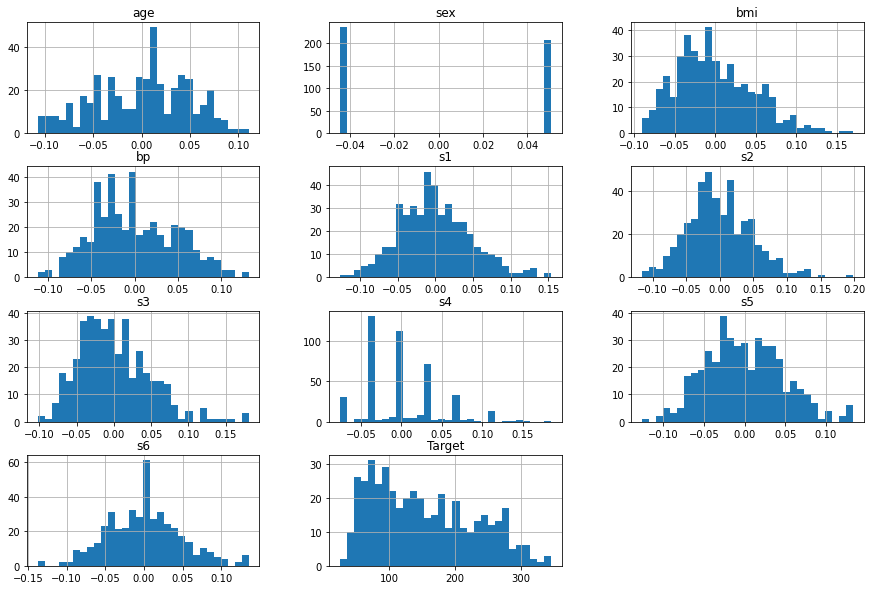

In [6]:
## histogram plot of predictors & targets ##
df = dfX.copy()
df['Target'] = sy
df.hist(bins=30,figsize=(15,10))
plt.show()

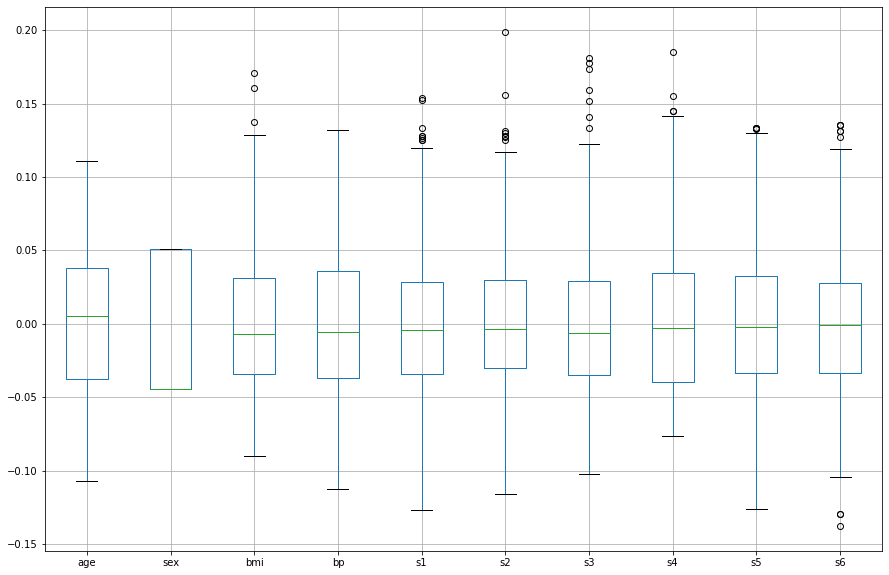

In [7]:
## boxplot of predictors ##
df.boxplot(column=dfX.columns.values.tolist(),figsize=(15,10))
plt.show()

The features follow various different distributions, and many show the presence of outliers. Outliers are apparent for bmi, s1, s2, s3, s4, s5, and s6. Note that the predictors have already been mean centered and scaled by the standard deviation such that the sum of squares equals 1.

To what degree are these features correlated? Let's take a look using the Pearson correlation:

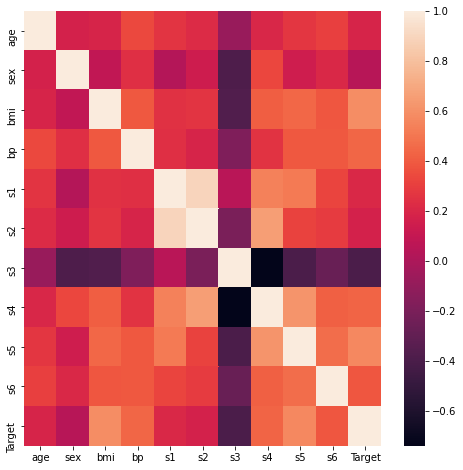

In [8]:
## plot the pearson correlation for our data ##
fig, ax = plt.subplots(figsize = (8, 8)) 
dfCorr  = df.corr() 
sn.heatmap(dfCorr) 
plt.show()

The heatmap indicates some interesting points: 

* s3 appears to be consistently anti-correlated with all other features + Target 
* s1 & s2 appear to be highly correlated
* The Target does not appear to be strongly correlated/anti-correlated with any single feature over the others

### Investigate Training Loss

At this stage, I want to look at how the training loss evolves as weak learners are added to the ensemble. The training loss has an odd shape, since we divide by the supremum. As we iterate through he ensemble, it is expected that the loss should start off near 0.0 and progress towards 0.5. At a loss of 0.5, the update rule for the sample weights no longer works, and as such training stops. The loss is expected to evolve this way since with each successive weak learner, the difference between the supremum and $abs(y^{pred}_i - y^{true}_i)$, for all $i$, should shrink. 

I will start with initialising the weak learner, which will be a regression decision stump:

In [9]:
## initialize a weak learner ##
weak_m = DecisionTreeRegressor(max_depth=1)

I will train the model on the raw data features, since decision trees typically require little feature engineering:

In [10]:
## train the adaboost regressor ##
rgr = AdaBoostRegressor(weak_learner=weak_m, loss='linear')
rgr.fit(dfX.values,sy.values)

In [11]:
## get linear loss ##
linear_loss = rgr.get_loss()

In [12]:
## train the adaboost regressor ##
rgr = AdaBoostRegressor(weak_learner=weak_m, loss='square')
rgr.fit(dfX.values,sy.values)

In [13]:
## get square loss ##
square_loss = rgr.get_loss()

In [14]:
## train the adaboost regressor ##
rgr = AdaBoostRegressor(weak_learner=weak_m, loss='exponential')
rgr.fit(dfX.values,sy.values)

In [15]:
## get exponential loss ##
exp_loss = rgr.get_loss()

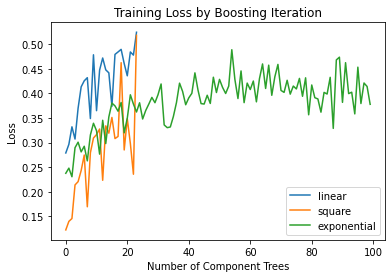

In [16]:
## plot the training loss ##
plt.plot(linear_loss,label='linear')
plt.plot(square_loss,label='square')
plt.plot(exp_loss,label='exponential')
plt.title('Training Loss by Boosting Iteration')
plt.xlabel('Number of Component Trees')
plt.ylabel('Loss')
plt.legend()
plt.show()

The linear and square loss functions terminate at around 20 weak learners. It is at this point  where the loss reaches 0.5 from an initial low value. The exponential loss does not reach 0.5, for the default number of weak learners in our Adaboost implementation (100). As such, training does not terminate early when using this loss function.

Regardless of the choice of loss function, the implementation appears to be functioning as we would expect. The loss starts at a low value, and proceeds towards 0.5 as more weak learner models are added to the ensemble. Once the loss reaches 0.5, training is terminated.

### Investigate Performance

**Note**: rerunning these cells will show some fluctuation in the results

Here I will use 10-fold cross-validation to measure the performance of the Adaboost regressor. I will use the linear loss, and set the maximum number of elements to 20:

In [17]:
## define the scoring metrics ##
scoring_metrics = {'mse' : make_scorer(mean_squared_error), 
                   'mae': make_scorer(mean_absolute_error)}

In [18]:
## perform cross-validation for linear loss & n_elements = 20 ##
#define the model
rgr = AdaBoostRegressor(weak_learner=weak_m, loss='linear', n_elements=20)
#cross validate
dcScores = cross_validate(rgr,dfX.values,sy.values,cv=10,scoring=scoring_metrics)
#report results
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))

Mean MSE: 3782.54
Mean MAE: 52.02


We can compare these results with the Adaboost regressor available from scikit-learn:

In [19]:
## import adaboost regressor from scikit-learn ##
from sklearn.ensemble import AdaBoostRegressor

In [20]:
## perform cross-validation for linear loss & n_elements=20 ##
#define the model
rgr = AdaBoostRegressor(base_estimator=weak_m, loss='linear', n_estimators=20)
#cross validate
dcScores = cross_validate(rgr,dfX.values,sy.values,cv=10,scoring=scoring_metrics)
#report results
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))

Mean MSE: 3827.65
Mean MAE: 52.40


We can see there is a small difference between the two Adaboost models. Note both Adaboost regressors are based on the same R2 algorithm.

Now let's compare our results with a lone weak learner, and a Random Forest Regressor with 20 constituent weak learners:

In [21]:
#cross validate
dcScores = cross_validate(weak_m,dfX.values,sy.values,cv=10,scoring=scoring_metrics)
#report results
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))

Mean MSE: 4751.55
Mean MAE: 56.68


In [22]:
## perform cross-validation for n_elements=20 & max_depth=1 ##
#define the model
rgr = RandomForestRegressor(n_estimators=20,max_depth=1)
#cross validate
dcScores = cross_validate(rgr,dfX.values,sy.values,cv=10,scoring=scoring_metrics)
#report results
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))

Mean MSE: 3935.18
Mean MAE: 52.12


Model | Number of Elements | MSE | MAE 
--- | --- | --- | ---
Custom Adaboost | 20 | 3782.54 | 52.02
Scikit-learn Adaboost | 20 | 3827.65 | 52.40
Decision Stump | NA | 4751.55 | 56.68
Scikit-Learn Random Forest | 20 | 3935.18| 52.12

The Adaboost regressors produce the best overall results, with both our custom implementation, and the one available from scikit-learn, yielding similar numbers. The Random Forest of 20 Decision Stumps performs a bit worse with respect to Adaboost. The lone Decision Stump shows the worst overall performance. 